In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [46]:
def analysis_plot(solution_df: pd.DataFrame):
    # Set 'time-step' as the index
    solution_df.set_index('time-step', inplace=True)

    # Create a figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Parameters over Time Steps')

    # Plot each parameter in a separate subplot
    for (param, ax) in zip(solution_df.columns, axs.ravel()):
        solution_df[param].plot(ax=ax, marker='o')
        ax.set_title(param)
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Value')
        ax.grid(True)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [65]:
def calculate_stats(df: pd.DataFrame):
    # Calculate mean and median for each column
    results = {}
    for column in df.columns:
        results[column] = {
            "mean": df[column].mean(),
            "median": df[column].median()
        }
    
    return results

In [47]:
solution_artem_v1_df = pd.read_json('../data/solution_artem_v1_analysis.json')
solution_example_df = pd.read_json('../data/solution_example_analysis.json')

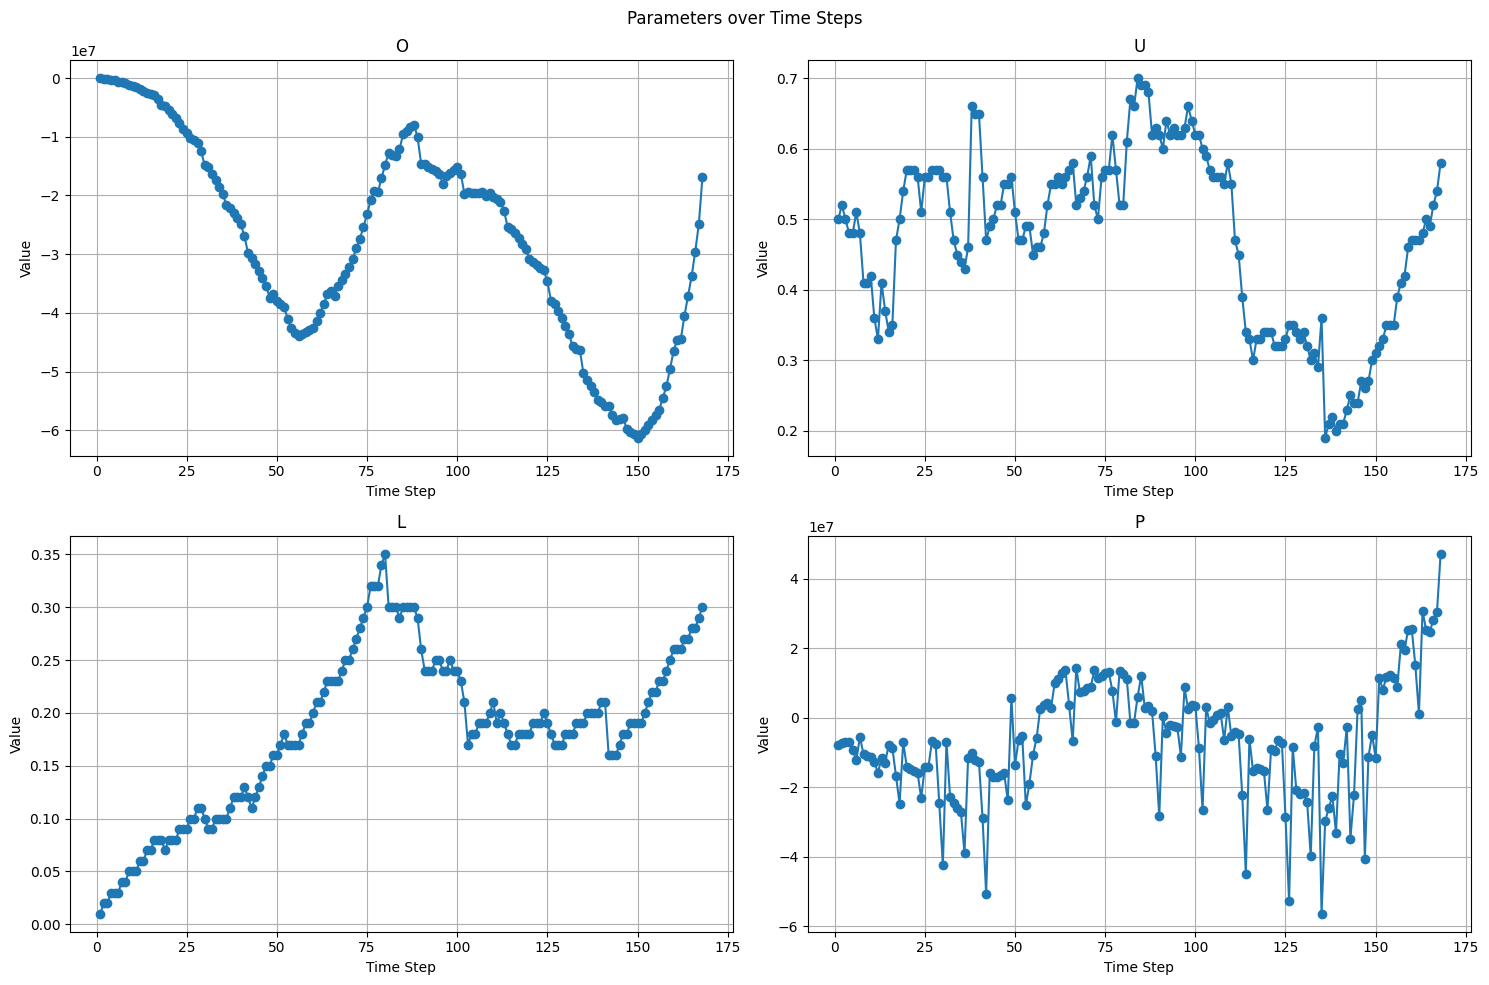

In [48]:
analysis_plot(solution_artem_v1_df)

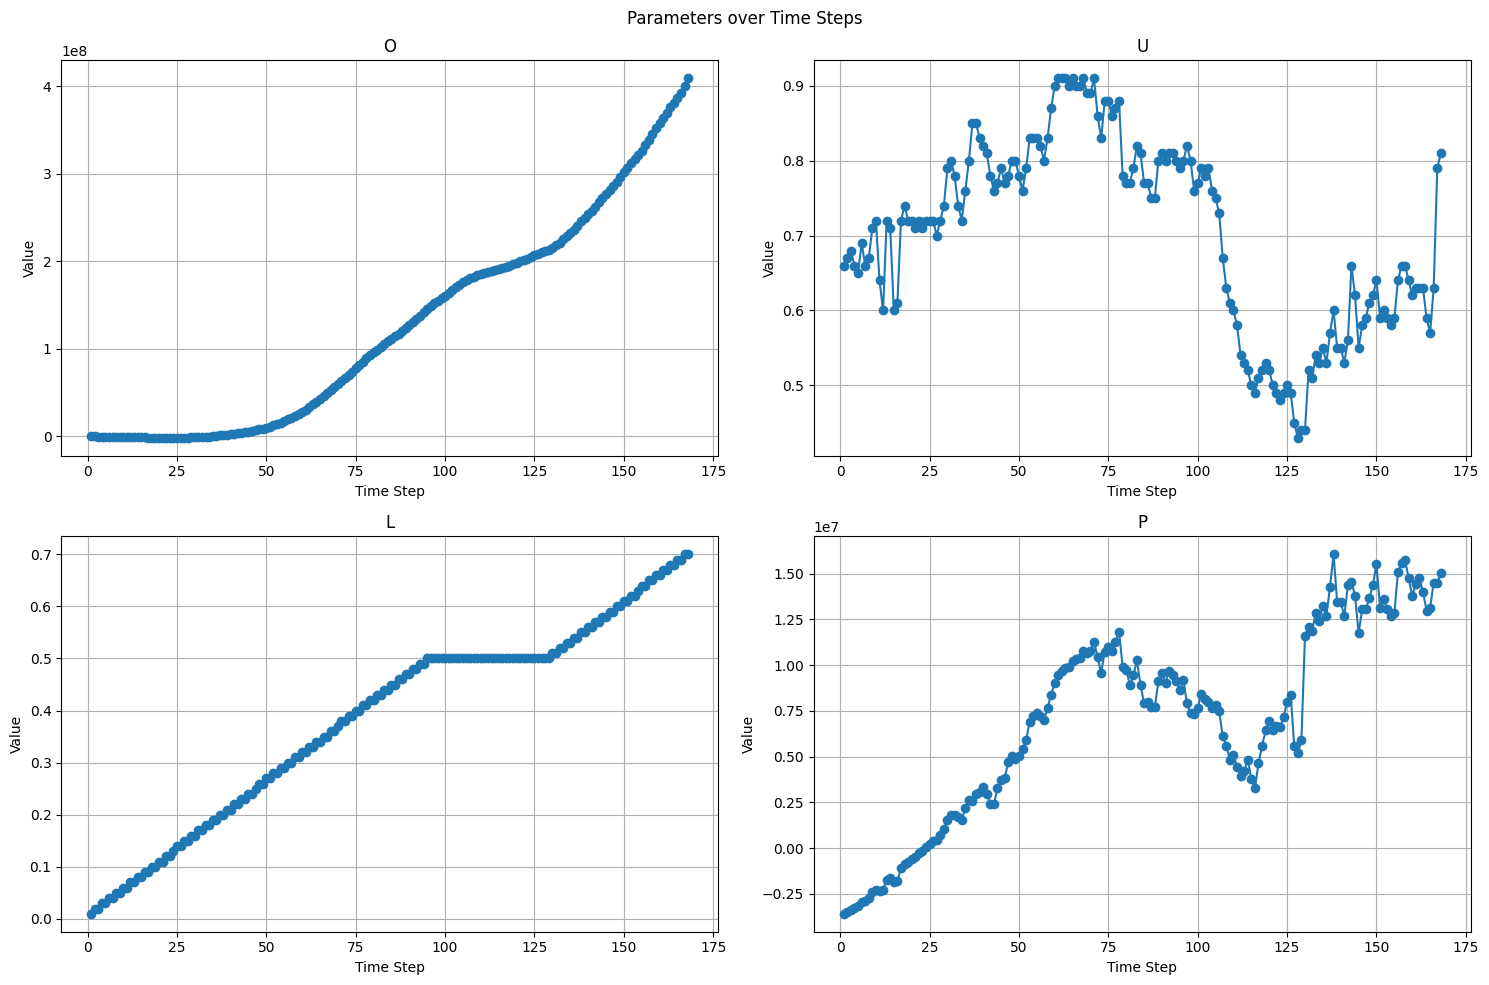

In [49]:
analysis_plot(solution_example_df)

In [66]:
calculate_stats(solution_artem_v1_df)

{'O': {'mean': -27852804.01446429, 'median': -26084058.265},
 'U': {'mean': 0.47380952380952385, 'median': 0.5},
 'L': {'mean': 0.1826785714285714, 'median': 0.19},
 'P': {'mean': -6449506.700238095, 'median': -6956102.975}}

In [67]:
calculate_stats(solution_example_df)

{'O': {'mean': 127125370.60351193, 'median': 110452169.08500001},
 'U': {'mean': 0.7030952380952381, 'median': 0.72},
 'L': {'mean': 0.3857738095238095, 'median': 0.445},
 'P': {'mean': 7056430.63470238, 'median': 7691781.155}}